# UNet Results

## Import Libraries

In [5]:
# Image Processing Libraries
import cv2
from cv2 import imread,resize
from scipy.ndimage import label, find_objects

# Data Handling Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# TensorFlow and Keras Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.utils import Sequence


# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import seaborn as sns
from tqdm import tqdm

# File and Operating System Libraries
import os
from glob import glob

# Warnings Management
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
# PATHS
IMG_PATH = 'chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/image/'
MSK_PATH = 'chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask/'

In [3]:
class DataGenerator(keras.utils.PyDataset):
    def __init__(self, img_files, mask_files, batch_size=32, size=(512, 512), seed=1, shuffle=True, **kwargs):
        """
        Custom data generator for segmentation tasks.

        Args:
        - img_dir: Directory containing the input images
        - mask_dir: Directory containing the corresponding masks
        - batch_size: Number of samples per batch
        - size: The target size for resizing the images and masks
        - seed: Random seed for reproducibility
        - shuffle: Whether to shuffle the dataset after each epoch
        """
        super().__init__(**kwargs)

        # List image and mask files
        self.img_filenames = img_files
        self.mask_filenames = mask_files

        self.batch_size = batch_size
        self.size = size
        self.seed = seed
        self.shuffle = shuffle

        # Ensure the number of images matches the number of masks
        assert len(self.img_filenames) == len(self.mask_filenames), \
            "The number of images and masks must be the same"

        self.indexes = np.arange(len(self.img_filenames))  # Indices for shuffling

        # If shuffle is enabled, shuffle the indices after each epoch
        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        """
        Returns the number of batches per epoch.
        """
        return int(np.floor(len(self.img_filenames) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates a batch of data (images and corresponding masks).

        Args:
        - index: The index of the batch.

        Returns:
        - A batch of images and masks
        """
        # Get batch indices
        batch_indices = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        # Initialize empty arrays for the batch
        images = []
        masks = []

        for i, idx in enumerate(batch_indices):
            # Load and preprocess image
            img = imread(IMG_PATH+self.img_filenames[idx],0)  # Read image
            img = resize(img, self.size)  # Resize to target size
            img = img / 255.0  # Normalize to [0, 1]

            # Load and preprocess mask
            mask = imread(MSK_PATH+self.mask_filenames[idx],0)  # Read mask
            mask = resize(mask, self.size)  # Resize to target size
            # mask = cv2.dilate(mask, np.ones((15, 15), np.uint8), iterations=1)
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
            mask = mask / 255.0  # Normalize to [0, 1]
            mask[mask > 0.5] = 1  # Binary mask

            # Add image and mask to the batch arrays
            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        """
        Shuffle the dataset after each epoch.
        """
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [6]:
img_files, msk_files = sorted(os.listdir(IMG_PATH)), sorted(os.listdir(MSK_PATH))

train_img_files, val_img_files, train_msk_files, val_msk_files = train_test_split(img_files,msk_files,test_size=0.3,random_state=1)

In [7]:
train_data = DataGenerator(
    img_files=train_img_files,
    mask_files=train_msk_files,
    batch_size=8,
    size=(512, 512),
    workers=4,
    use_multiprocessing=True
)

val_data = DataGenerator(
    img_files=val_img_files,
    mask_files=val_msk_files,
    batch_size=8,
    size=(512, 512),
    workers=4,
    use_multiprocessing=True
)

## Load Model

### Loss functions

In [8]:
# Jaccard Index Metric
def jaccard_index(y_true, y_pred, smooth=100):
    """Calculates the Jaccard index (IoU), useful for evaluating the model's performance."""
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])  # Flatten and cast ground truth
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])  # Flatten and cast predictions
    intersection = tf.reduce_sum(y_true_f * y_pred_f)  # Compute intersection
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection  # Total pixels
    return (intersection + smooth) / (total + smooth)


def dice_coefficient(y_true, y_pred, smooth=1):
    # Flatten and cast true and predicted masks to float32
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])  # Flatten and cast y_true to float32
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])  # Flatten and cast y_pred to float32

    # Calculate the intersection between the true and predicted masks
    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    # Calculate the Dice coefficient using the formula
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [9]:
custom_objects = {"dice_coefficient": dice_coefficient, "jaccard_index": jaccard_index}

model = keras.models.load_model("models/unet_best_model.keras", custom_objects=custom_objects)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 512, 512,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 512, 512,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 256, 256,  │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 256, 256,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │  1,180,160 │ max_pooling2d_5[

 Total params: 23,111,109 (88.16 MB)

 Trainable params: 7,701,825 (29.38 MB)

 Non-trainable params: 5,632 (22.00 KB)

 Optimizer params: 15,403,652 (58.76 MB)

In [11]:
def get_colored_mask(image, mask_image,color = [255,20,255]):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    mask_coord = np.where(mask!=[0,0,0])
    mask[mask_coord[0],mask_coord[1],:]= color
    ret = cv2.addWeighted(image, 0.6, mask, 0.4, 0)
    return ret

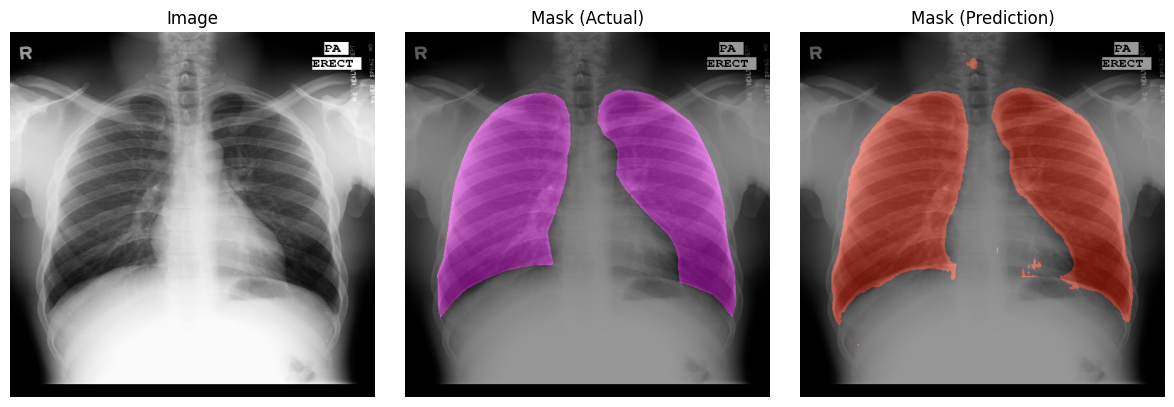

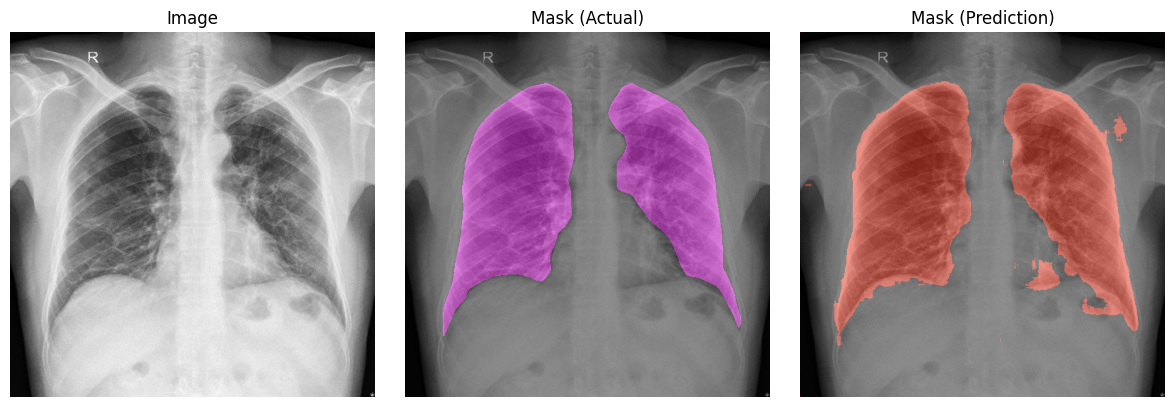

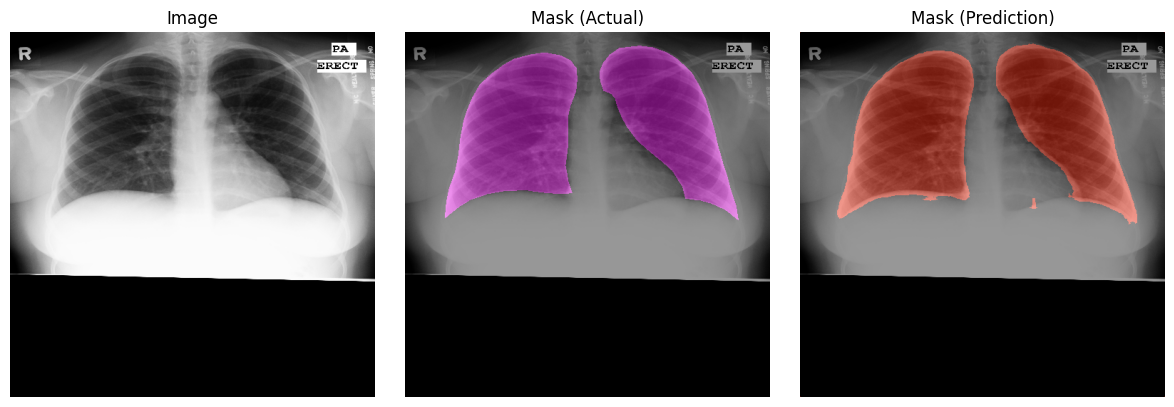

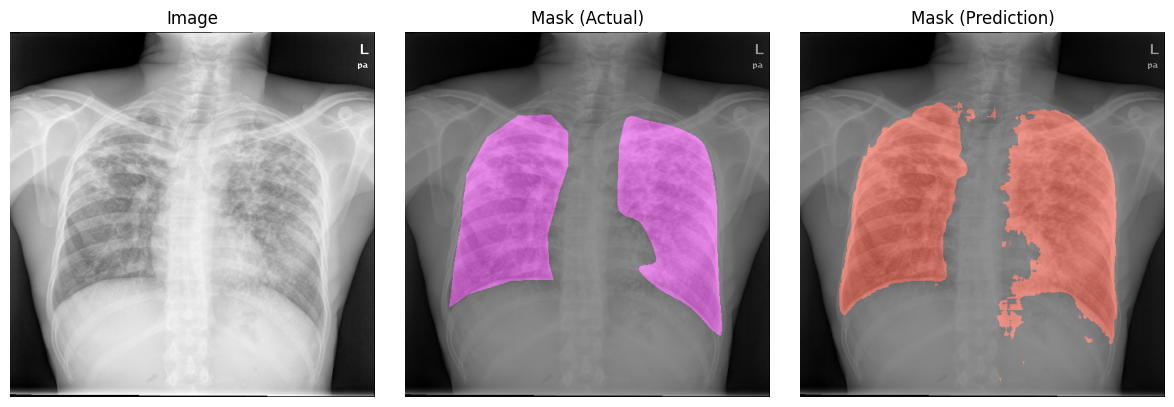

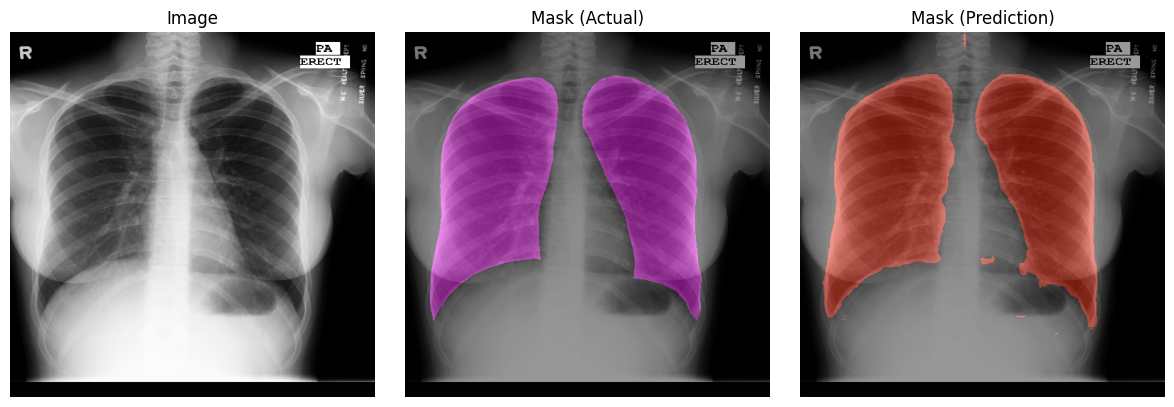

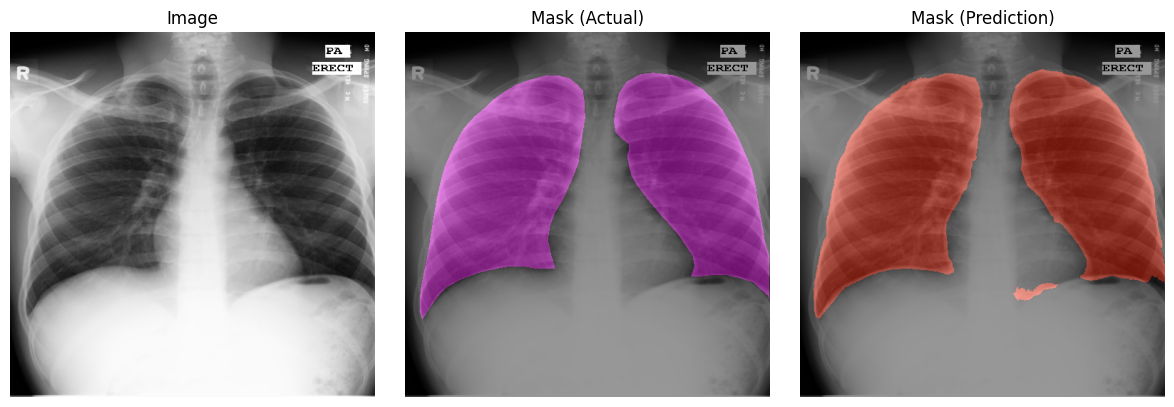

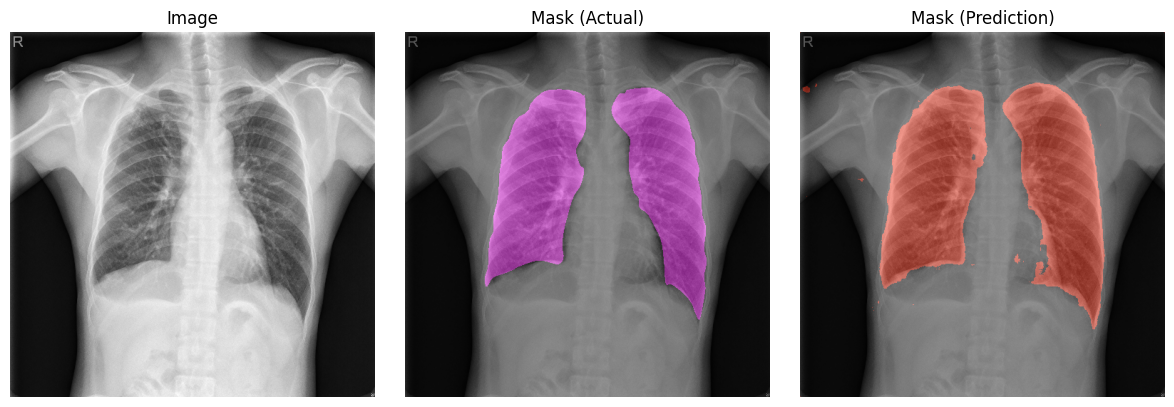

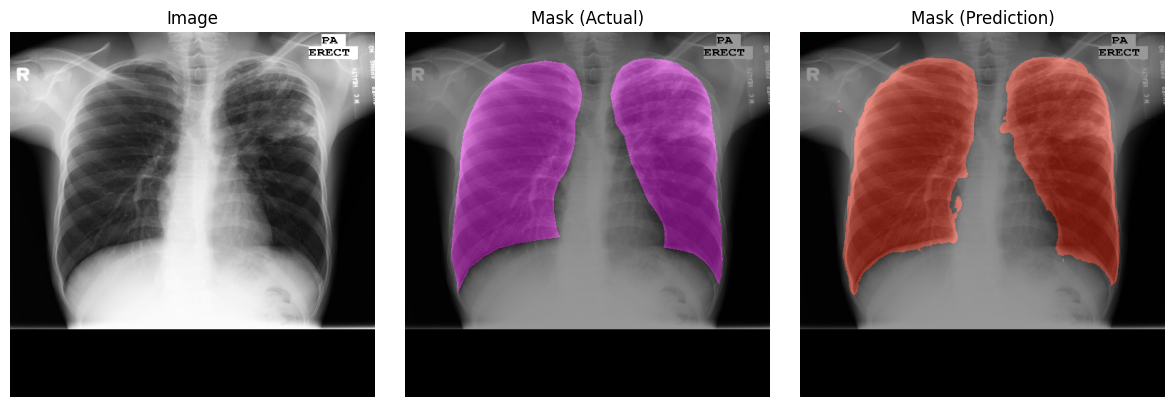

In [12]:
imgs, msks  = val_data.__getitem__(1)

for img,msk in zip(imgs,msks):
    img = np.expand_dims(img, axis=0)
    pred = (np.squeeze(model.predict(img,verbose=0))*255).astype(np.uint8)
    img = (np.squeeze(img) * 255).astype(np.uint8)
    msk = (msk*255).astype(np.uint8)

    # Convert grayscale image to RGB
    img= cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    msk = cv2.cvtColor(msk, cv2.COLOR_GRAY2RGB)
    pred = cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB)
    
    plt.figure(figsize=(12,4))

    plt.subplot(131)
    plt.imshow(img)
    plt.title('Image')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)
    
    plt.subplot(132)
    plt.imshow(get_colored_mask(img,msk))
    plt.title('Mask (Actual)')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.subplot(133)
    plt.imshow(get_colored_mask(img,pred,color = [255,30,0]))
    plt.title('Mask (Prediction)')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.tight_layout()
    plt.show()